In [1]:
import pandas as pd

# Load the data
data_df = pd.read_csv('data/goemotions_cleaned.csv')

# remove the rows with null values
data_df = data_df.dropna()

data_df_sample = data_df

# Function to sample 1000 sentences for each group
def sample_sentences(group):
    return group.sample(min(len(group), 10000))

# Apply the function to each group and concatenate the results
data_df_sample = data_df.groupby('emotion').apply(sample_sentences).reset_index(drop=True)

# Shuffle the data
data_df_sample = data_df_sample.sample(frac=1).reset_index(drop=True)

sequences = data_df_sample['sentence'].tolist()
labels = data_df_sample['emotion'].tolist()

print(data_df_sample.value_counts('emotion'))

emotion
anger        10000
disgust      10000
happiness    10000
sadness      10000
surprise     10000
fear          6920
Name: count, dtype: int64


/tmp/ipykernel_104237/3537599619.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_df_sample = data_df.groupby('emotion').apply(sample_sentences).reset_index(drop=True)


In [2]:
data_df_sample.head(5)

,sentence,emotion
0,I don't feel alive anymore. I don't feel anyth...,sadness
1,Maybe Orlando for Bolts vs Cats? Or Daytona mi...,surprise
2,After all that i expected it to not look terri...,fear
3,I was eating watching tonight's episode. OMG I...,happiness
4,this guy is such a douchebag,anger


In [3]:
from sklearn.model_selection import train_test_split

# anger, disgust, fear, happiness, sadness, surprise
label_mapping = {
    'anger': 0,
    'disgust': 1,
    'fear': 2,
    'happiness': 3,
    'sadness': 4,
    'surprise': 5
}

# Encode the labels manually
labels = [label_mapping[label] for label in labels]

# Split
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

In [4]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

import tensorflow as tf

# Load the pre-trained model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=6)

# Tokenize the input
train_batch = tokenizer(X_train, padding=True, truncation=True, return_tensors="tf")
val_batch = tokenizer(X_test, padding=True, truncation=True, return_tensors="tf")

# Prepare the datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_batch), y_train)).shuffle(10000).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_batch), y_test)).batch(64)

2024-04-09 19:44:33.651426: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 19:44:33.651466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 19:44:33.652687: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-09 19:44:33.659170: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 19:44:36.105176: W tensorflow/core/common_

In [5]:
# Define optimization parameters

learning_rate = 2e-5  # Set your desired learning rate here
batch_size = 32
num_epochs = 100

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric,
)
model.summary()

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  124055040 
 r)                                                              
                                                                 
 classifier (TFRobertaClass  multiple                  595206    
 ificationHead)                                                  
                                                                 
Total params: 124650246 (475.50 MB)
Trainable params: 124650246 (475.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=4
)

# Distribution of classes
class_distribution = {
    'anger': 10000,
    'disgust': 10000,
    'fear': 6920,
    'happiness': 10000,
    'sadness': 10000,
    'surprise': 10000
}

# Calculate class weights
total_samples = sum(class_distribution.values())
class_weights = {label_mapping[label]: total_samples / (len(class_distribution) * count) for label, count in class_distribution.items()} 

print(class_weights)

history = model.fit(
    train_dataset,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

{0: 0.9486666666666667, 1: 0.9486666666666667, 2: 1.3709055876685934, 3: 0.9486666666666667, 4: 0.9486666666666667, 5: 0.9486666666666667}
Epoch 1/100


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2024-04-09 19:45:53.197168: I external/local_xla/xla/service/service.cc:168] XLA service 0x7efe770a1cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-09 19:45:53.197981: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-04-09 19:45:53.213500: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-09 19:45:53.259602: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1712691953.384230  104904 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1423/1423 [==============================] - 373s 196ms/step - loss: 1.2351 - accuracy: 0.5360 - val_loss: 1.1459 - val_accuracy: 0.5798
Epoch 2/100
1423/1423 [==============================] - 254s 179ms/step - loss: 1.0849 - accuracy: 0.5994 - val_loss: 1.1324 - val_accuracy: 0.5820
Epoch 3/100
1423/1423 [==============================] - 255s 179ms/step - loss: 1.0017 - accuracy: 0.6306 - val_loss: 1.1623 - val_accuracy: 0.5721
Epoch 4/100
1423/1423 [==============================] - 251s 176ms/step - loss: 0.9217 - accuracy: 0.6599 - val_loss: 1.2023 - val_accuracy: 0.5685
Epoch 5/100
1423/1423 [==============================] - 252s 177ms/step - loss: 0.8443 - accuracy: 0.6843 - val_loss: 1.2693 - val_accuracy: 0.5632
Epoch 6/100
1423/1423 [==============================] - 253s 177ms/step - loss: 0.7727 - accuracy: 0.7080 - val_loss: 1.3211 - val_accuracy: 0.5597
Epoch 6: early stopping


In [7]:
model.save_pretrained("models/roberta_multi_model_v6")

In [9]:
# with the test data, do error analysis and create a confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np

# Get the predictions
y_pred = model.predict(val_dataset)

# Get the predicted classes
y_pred = np.argmax(y_pred.logits, axis=1)

# Get the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print(conf_matrix)

178/178 [==============================] - 28s 105ms/step
[[ 823  374   80  128  294  284]
 [ 343  863   96   98  264  294]
 [  57   53 1079   49   92   63]
 [ 116  110   48 1256  139  327]
 [ 204  260  122  139 1107  201]
 [ 138  171   53  232  183 1244]]


In [10]:
# Calculate metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.5597329585382994
Precision: 0.5580770584402805
Recall: 0.5597329585382994
F1 Score: 0.5573384346922768


In [11]:
print(classification_report(y_test, y_pred, target_names=label_mapping.keys()))

              precision    recall  f1-score   support

       anger       0.49      0.42      0.45      1983
     disgust       0.47      0.44      0.46      1958
        fear       0.73      0.77      0.75      1393
   happiness       0.66      0.63      0.64      1996
     sadness       0.53      0.54      0.54      2033
    surprise       0.52      0.62      0.56      2021

    accuracy                           0.56     11384
   macro avg       0.57      0.57      0.57     11384
weighted avg       0.56      0.56      0.56     11384



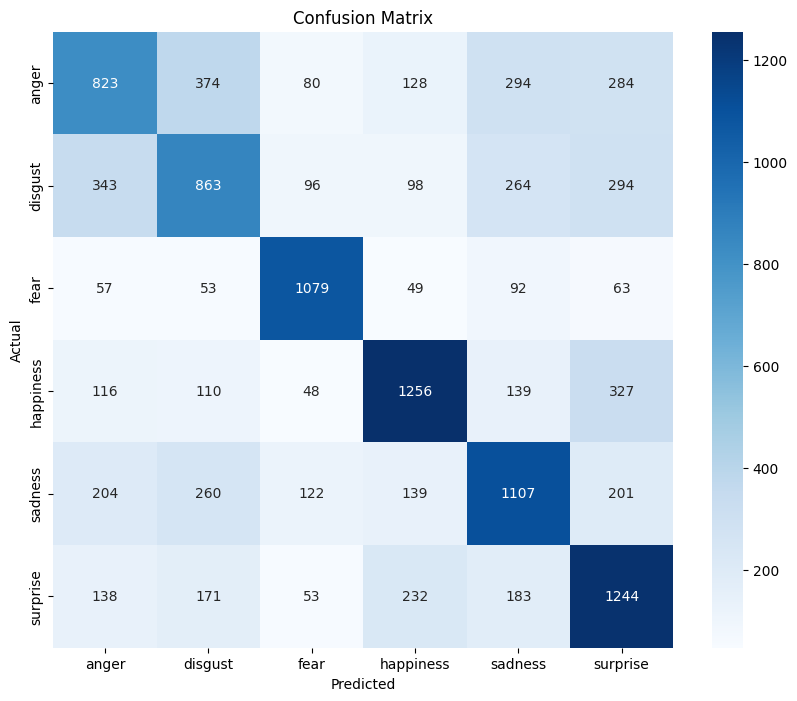

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()